# Noise Robustness Analysis

This notebook generates:
1. Success Rate vs Position Noise bar plot
2. Break Rate vs Position Noise bar plot
3. LaTeX table for nominal performance

In [156]:
# ============================================================
# BLOCK 1: IMPORTS & LOCAL CONFIGURATION
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

# Import and reload shared utilities (reload picks up changes without rerunning blocks 2-3)
import analysis_utils
importlib.reload(analysis_utils)
from analysis_utils import (
    # Constants
    ENTITY, PROJECT, COLORS,
    TAG_EVAL_PERFORMANCE, TAG_EVAL_NOISE,
    METRIC_SUCCESS, METRIC_BREAKS, METRIC_TOTAL,
    # Data functions
    get_best_checkpoint_per_run,
    download_eval_data,
    download_eval_performance_data,
    filter_top_n_runs,
    # Plotting functions
    plot_rate_figure,
    print_data_summary,
)

# ============================================================
# LOCAL CONFIGURATION (specific to this analysis)
# ============================================================

# Method Tags
METHOD_TAGS = {
    # Unbreakable
    #"Pose(1mm)": "pose_base-case:2026-02-02_13:40",
    #"Pose(2.5mm)": "pose_25mm:2026-02-02_13:40",
    #"MATCH(1mm)": "MATCH_base-case:2026-02-04_17:46",
    #"Hybrid-Basic(1mm)": "basic-hybrid_base-case:2026-02-02_13:40",
    # 10N
    #"Pose-1": "pose_breakable_f10N:2026-02-04_17:49",
    #"Pose-2.5": "pose_25mm_f10:2026-02-05_22:12",
    #"MATCH": "MATCH_breakable_10N:2026-02-04_17:49",
    #"Hybrid": "basic-hybrid_breakable_f10N:2026-02-04_17:49",

    #"VIC":  "pose_vic_squashed_breakable_f10:2026-02-21_10:59",
    #"Pose(1mm)": "pose_squashed_breakable_f10:2026-02-21_10:59",
    #"Pose(2.5mm)":"pose_squashed_25mm_f10:2026-02-22_14:24",
    #"Hybrid-Basic": "hybrid_squashed_breakable_f10:2026-02-21_10:59",
    #"Hybrid-MATCH": "MATCH_squashed_breakable_f10:2026-02-21_10:59",

    # DR Results
    "Pose(1mm)": "pose_DR_breakable_f10:2026-02-25_14:14",
    # "Pose(2.5mm)":"",
    "Hybrid-Basic":"hybrid_DR_breakable_f10:2026-02-25_14:14",
    "Hybrid-MATCH":"MATCH_DR_breakable_f10:2026-02-25_14:14",
}

# Noise Level Mapping: display label -> metric range string
NOISE_LEVELS = {
    "1mm": "0mm-1mm",
    "2.5mm": "1mm-2.5mm",
    "5mm": "2.5mm-5mm",
    "7.5mm": "5mm-7.5mm",
}

# Old Noise Eval Filter: None, "include", or "exclude"
OLD_NOISE_EVAL_FILTER = "exclude"

# Policy Selection
TOP_N_POLICIES = None  # Set to integer (e.g., 3) to use top N policies, or None for all
MAX_CHECKPOINT = None  # Set to int to limit checkpoint search (e.g., 2000000 for first 2M steps)

# Plot Configuration
SUCCESS_Y_LIM = (0, 100)
SUCCESS_Y_TICKS = [0, 20, 40, 60, 80, 100]
BREAK_Y_LIM = (0, 7)
BREAK_Y_TICKS = list(range(7))

# Error type: "ci" for 95% confidence interval, "binary_se" for binary standard error
ERROR_TYPE = "ci"

# Extra metrics for performance data
EXTRA_PERF_METRICS = ["avg_steps_to_success", "avg_force_in_contact"]

In [157]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

api = wandb.Api()
best_checkpoints_by_method = {}

for method_name, method_tag in METHOD_TAGS.items():
    print(f"\n{method_name} ({method_tag}):")
    best_checkpoints_by_method[method_name] = get_best_checkpoint_per_run(
        api, method_tag, max_checkpoint=MAX_CHECKPOINT
    )


Pose(1mm) (pose_DR_breakable_f10:2026-02-25_14:14):
  Eval_performance_pose_DR_breakable_f(10)_0: best checkpoint at step 2188800 (score: 90)
  Eval_performance_pose_DR_breakable_f(10)_1: best checkpoint at step 2457600 (score: 90)
  Eval_performance_pose_DR_breakable_f(10)_2: best checkpoint at step 1689600 (score: 94)
  Eval_performance_pose_DR_breakable_f(10)_3: best checkpoint at step 2572800 (score: 91)
  Eval_performance_pose_DR_breakable_f(10)_4: best checkpoint at step 38400 (score: 0)

Hybrid-Basic (hybrid_DR_breakable_f10:2026-02-25_14:14):
  Eval_performance_hybrid_DR_breakable_f(10)_0: best checkpoint at step 2764800 (score: 86)
  Eval_performance_hybrid_DR_breakable_f(10)_1: best checkpoint at step 2803200 (score: 95)
  Eval_performance_hybrid_DR_breakable_f(10)_2: best checkpoint at step 2304000 (score: 92)
  Eval_performance_hybrid_DR_breakable_f(10)_3: best checkpoint at step 2956800 (score: 88)
  Eval_performance_hybrid_DR_breakable_f(10)_4: best checkpoint at step 25

In [158]:
# ============================================================
# BLOCK 3: DOWNLOAD DATA
# ============================================================

print(f"Old Noise Eval Filter: {OLD_NOISE_EVAL_FILTER}")

# Download noise evaluation data
noise_data = {}
for method_name, method_tag in METHOD_TAGS.items():
    print(f"\nDownloading noise data for {method_name}...")
    noise_data[method_name] = download_eval_data(
        api=api,
        method_tag=method_tag,
        best_checkpoints=best_checkpoints_by_method[method_name],
        level_mapping=NOISE_LEVELS,
        prefix_template="Noise_Eval({level})_Core",
        level_col_name="noise_level",
        eval_tag=TAG_EVAL_NOISE,
        old_noise_filter=OLD_NOISE_EVAL_FILTER,
    )

# Download performance data (for LaTeX table)
perf_data = {}
for method_name, method_tag in METHOD_TAGS.items():
    print(f"Downloading performance data for {method_name}...")
    perf_data[method_name] = download_eval_performance_data(
        api=api,
        method_tag=method_tag,
        best_checkpoints=best_checkpoints_by_method[method_name],
        extra_metrics=EXTRA_PERF_METRICS,
    )

# Print summary
print_data_summary(
    data=noise_data,
    level_labels=list(NOISE_LEVELS.keys()),
    level_col="noise_level",
    metric="success",
    title="NOISE DATA SUMMARY (Success Rate)",
)

Old Noise Eval Filter: exclude



NOISE DATA SUMMARY (Success Rate)

Pose(1mm):
  1mm: 75.0% (n=5)
  2.5mm: 68.4% (n=5)
  5mm: 46.6% (n=5)
  7.5mm: 21.2% (n=5)

Hybrid-Basic:
  1mm: 94.4% (n=5)
  2.5mm: 87.2% (n=5)
  5mm: 58.6% (n=5)
  7.5mm: 25.1% (n=5)

Hybrid-MATCH:
  1mm: 70.3% (n=5)
  2.5mm: 63.1% (n=5)
  5mm: 42.6% (n=5)
  7.5mm: 19.0% (n=5)


In [159]:
importlib.reload(analysis_utils)
from analysis_utils import (
    COLORS, plot_rate_figure, 
    plot_rate_figure_by_method, NOISE_LEVEL_COLORS, 
    print_data_summary, filter_top_n_runs
)

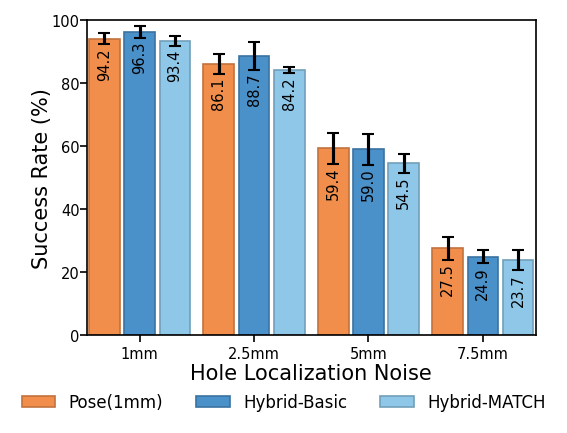

In [175]:
# ============================================================
# BLOCK 4: SUCCESS RATE VS POSITION NOISE
# ============================================================
TOP_N_POLICIES = 3
fig, ax = plot_rate_figure(
    data=noise_data,
    method_names=list(METHOD_TAGS.keys()),
    level_labels=list(NOISE_LEVELS.keys()),
    level_col="noise_level",
    metric="success",
    #title="Success Rate vs Hole Position Noise",
    x_label="Hole Localization Noise",
    y_label="Success Rate (%)",
    y_lim=SUCCESS_Y_LIM,
    y_ticks=SUCCESS_Y_TICKS,
    error_type=ERROR_TYPE,
    filter_top_n=TOP_N_POLICIES,
    best_checkpoints=best_checkpoints_by_method,
    figsize= (3.5, 2.6),
    #legend_position='none'
)
plt.show()

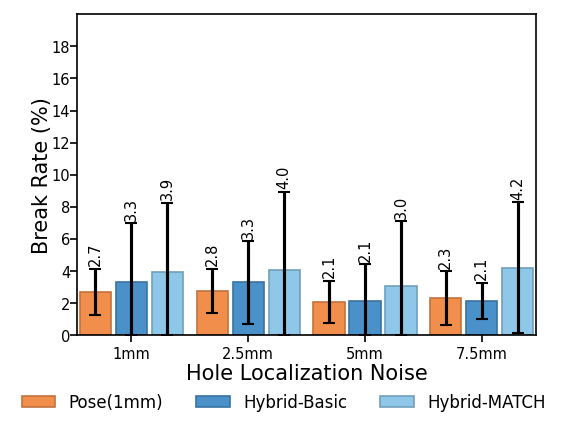

In [161]:
# ============================================================
# BLOCK 5: BREAK RATE VS POSITION NOISE
# ============================================================
BREAK_Y_LIM = [0,20]
BREAK_Y_TICKS = []
for x in range(BREAK_Y_LIM[-1]):
    if x%2==0:
        BREAK_Y_TICKS.append(x)
fig, ax = plot_rate_figure(
    data=noise_data,
    method_names=list(METHOD_TAGS.keys()),
    level_labels=list(NOISE_LEVELS.keys()),
    level_col="noise_level",
    metric="breaks",
    #title="Break Rate vs Position Noise",
    x_label="Hole Localization Noise",
    y_label="Break Rate (%)",
    y_lim=BREAK_Y_LIM,
    y_ticks=BREAK_Y_TICKS,
    error_type=ERROR_TYPE,
    filter_top_n=TOP_N_POLICIES,
    best_checkpoints=best_checkpoints_by_method,
)
plt.show()

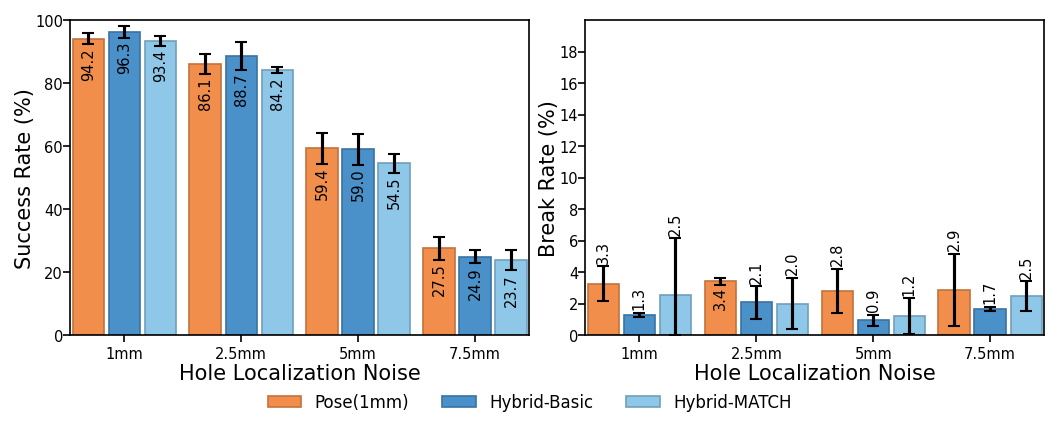

In [176]:
# ============================================================
# BLOCK 5b: COMBINED SUCCESS & BREAK RATE (SIDE-BY-SIDE)
# ============================================================
importlib.reload(analysis_utils)
from analysis_utils import (
    compute_rates, plot_grouped_bars, _apply_legend,
    COLORS, FONT_AXIS_LABEL, FONT_TITLE, FONT_TICK, FONT_LEGEND,
    AXIS_LABEL_PAD_X, AXIS_LABEL_PAD_Y, TICK_PAD_X, TICK_PAD_Y,
    AXIS_MARGIN_X, LEGEND_HANDLE_LENGTH, LEGEND_COLUMN_SPACING,
    LEGEND_Y_OFFSET,
    DEFAULT_LEGEND_POSITION, DEFAULT_GROUP_WIDTH, DEFAULT_BAR_GAP,
    DEFAULT_EDGE_DARKEN, DEFAULT_EDGE_LINEWIDTH, DEFAULT_BOLD_LABELS,
    DEFAULT_SHOW_LABEL_CI, DEFAULT_SATURATION,
    TIGHT_PAD, TIGHT_W_PAD, TIGHT_H_PAD,
)

method_names = list(METHOD_TAGS.keys())
level_labels = list(NOISE_LEVELS.keys())

COMBINED_FIGSIZE = (7.0, 2.6)
LEGEND_POS = DEFAULT_LEGEND_POSITION

panels = [
    {"metric": "success", "y_label": "Success Rate (%)", "y_lim": SUCCESS_Y_LIM, "y_ticks": SUCCESS_Y_TICKS},
    {"metric": "breaks",  "y_label": "Break Rate (%)",   "y_lim": BREAK_Y_LIM,   "y_ticks": BREAK_Y_TICKS},
]

fig, axes = plt.subplots(1, 2, figsize=COMBINED_FIGSIZE, dpi=150)

for ax, panel in zip(axes, panels):
    data_by_method = {}
    for method_name in method_names:
        if method_name not in noise_data:
            continue
        df = noise_data[method_name]
        if TOP_N_POLICIES is not None and method_name in best_checkpoints_by_method:
            df = filter_top_n_runs(df, best_checkpoints_by_method[method_name], TOP_N_POLICIES)
        means, errors, errors_lower, errors_upper = compute_rates(
            df, level_labels, "noise_level", panel["metric"], "total", ERROR_TYPE
        )
        data_by_method[method_name] = (means, errors_lower, errors_upper)

    x = np.arange(len(level_labels))
    plot_grouped_bars(ax, x, data_by_method, method_names, COLORS, show_labels=True, y_lim=panel["y_lim"])

    ax.set_xlabel("Hole Localization Noise", fontsize=FONT_AXIS_LABEL, labelpad=AXIS_LABEL_PAD_X)
    ax.set_ylabel(panel["y_label"], fontsize=FONT_AXIS_LABEL, labelpad=AXIS_LABEL_PAD_Y)
    ax.set_xticks(x)
    ax.set_xticklabels(level_labels, fontsize=FONT_TICK)
    ax.set_ylim(panel["y_lim"])
    if panel["y_ticks"] is not None:
        ax.set_yticks(panel["y_ticks"])
    ax.tick_params(axis="x", labelsize=FONT_TICK, pad=TICK_PAD_X)
    ax.tick_params(axis="y", labelsize=FONT_TICK, pad=TICK_PAD_Y)
    ax.margins(x=AXIS_MARGIN_X)
    for spine in ax.spines.values():
        spine.set_zorder(3)

# Single shared legend
_apply_legend(axes[0], LEGEND_POS, legend_loc="best", fig=fig)

plt.tight_layout(pad=TIGHT_PAD, w_pad=TIGHT_W_PAD, h_pad=TIGHT_H_PAD)
plt.show()

In [163]:
# ============================================================
# BLOCK 6: LATEX TABLE - NOMINAL PERFORMANCE
# ============================================================

# Display Options
SHOW_READABLE_PREVIEW = False  # Set to False to skip the readable table preview
INCLUDE_BREAK_RATE = True  # Set to False to remove the Break column from the table

# Table Configuration
TABLE_CAPTION = "Nominal performance on FPiH with round peg at 1mm training noise. Results averaged over 5 seeds. Best performance per metric in \\textbf{bold}."
TABLE_LABEL = "tab:nominal_performance"
DECIMAL_PLACES = 1

# Metrics: (display_name, stat_key, higher_is_better)
TABLE_METRICS = [
    ("Success", "success_rate", True),
    ("Break", "break_rate", False),
    ("Time (s)", "time", False),
    ("Force (N)", "force", False),
]

# Filter out Break column if not included
if not INCLUDE_BREAK_RATE:
    TABLE_METRICS = [m for m in TABLE_METRICS if m[0] != "Break"]

def format_mean_ci(mean, std, n_seeds, decimal=1):
    """Format mean ± 95% CI (1.96 * SEM)."""
    sem = std / np.sqrt(n_seeds)
    ci = 1.96 * sem
    return f"{mean:.{decimal}f} $\\pm$ {ci:.{decimal}f}"

def bold_if_best(value_str, is_best):
    if is_best:
        return f"\\textbf{{{value_str}}}"
    return value_str

# Compute statistics for each method
stats = {}
for method_name, df in perf_data.items():
    if df.empty:
        continue
    
    # Filter to top N if specified
    if TOP_N_POLICIES is not None:
        df = filter_top_n_runs(df, best_checkpoints_by_method[method_name], TOP_N_POLICIES, match_by="run_id")
    
    df = df.copy()
    df["success_rate"] = 100 * df["success"] / df["total"]
    df["break_rate"] = 100 * df["breaks"] / df["total"]
    df["time"] = df["avg_steps_to_success"] / 15.0  # Convert to seconds
    df["force"] = df["avg_force_in_contact"]
    
    n_seeds = len(df)
    
    # For time and force, only include runs with success > 0
    df_with_success = df[df["success_rate"] > 0]
    n_seeds_success = len(df_with_success)
    
    stats[method_name] = {
        "success_rate": (df["success_rate"].mean(), df["success_rate"].std(), n_seeds),
        "break_rate": (df["break_rate"].mean(), df["break_rate"].std(), n_seeds),
        "time": (df_with_success["time"].mean(), df_with_success["time"].std(), n_seeds_success) if n_seeds_success > 0 else (np.nan, np.nan, 0),
        "force": (df_with_success["force"].mean(), df_with_success["force"].std(), n_seeds_success) if n_seeds_success > 0 else (np.nan, np.nan, 0),
    }

# Determine best values
best_values = {}
for display_name, stat_key, higher_is_better in TABLE_METRICS:
    means = [(method, stats[method][stat_key][0]) for method in stats]
    if higher_is_better:
        best_method = max(means, key=lambda x: x[1])[0]
    else:
        best_method = min(means, key=lambda x: x[1])[0]
    best_values[stat_key] = best_method

# ---- READABLE TABLE PREVIEW ----
if SHOW_READABLE_PREVIEW:
    def format_mean_ci_plain(mean, std, n_seeds, decimal=1):
        """Format mean +/- 95% CI for plain text output."""
        sem = std / np.sqrt(n_seeds)
        ci = 1.96 * sem
        return f"{mean:.{decimal}f} +/- {ci:.{decimal}f}"

    print("=" * 80)
    print("TABLE VALUES PREVIEW")
    print("=" * 80)

    # Build header
    header_labels = ["Method"] + [f"{m} {'(+)' if h else '(-)'}" for m, _, h in TABLE_METRICS]
    col_widths = [max(20, len(h) + 2) for h in header_labels]
    col_widths[0] = 22  # Method column wider

    header_line = "".join(h.ljust(w) for h, w in zip(header_labels, col_widths))
    print(header_line)
    print("-" * len(header_line))

    # Build data rows
    for method_name in METHOD_TAGS.keys():
        if method_name not in stats:
            continue
        row_cells = [method_name]
        for display_name, stat_key, _ in TABLE_METRICS:
            mean, std, n_seeds = stats[method_name][stat_key]
            value_str = format_mean_ci_plain(mean, std, n_seeds, DECIMAL_PLACES)
            if best_values[stat_key] == method_name:
                value_str = f"*{value_str}*"
            row_cells.append(value_str)
        row_line = "".join(c.ljust(w) for c, w in zip(row_cells, col_widths))
        print(row_line)

    print("-" * len(header_line))
    print("* = best in column")
    print()

# ---- LATEX TABLE ----
UP_ARROW = "$\\uparrow$"
DOWN_ARROW = "$\\downarrow$"
header_parts = [f"{m} {UP_ARROW if h else DOWN_ARROW}" for m, _, h in TABLE_METRICS]
header_row = "Method & " + " & ".join(header_parts) + " \\\\"

latex_lines = [
    "\\begin{table}[t]",
    "\\centering",
    f"\\caption{{{TABLE_CAPTION}}}",
    f"\\label{{{TABLE_LABEL}}}",
    "\\begin{tabular}{l" + "c" * len(TABLE_METRICS) + "}",
    "\\toprule",
    header_row,
    "\\midrule",
]

for method_name in METHOD_TAGS.keys():
    if method_name not in stats:
        continue
    
    cells = [method_name]
    for display_name, stat_key, _ in TABLE_METRICS:
        mean, std, n_seeds = stats[method_name][stat_key]
        value_str = format_mean_ci(mean, std, n_seeds, DECIMAL_PLACES)
        is_best = (best_values[stat_key] == method_name)
        cells.append(bold_if_best(value_str, is_best))
    
    latex_lines.append(" & ".join(cells) + " \\\\")

latex_lines.extend([
    "\\bottomrule",
    "\\end{tabular}",
    "\\end{table}",
])

latex_output = "\n".join(latex_lines)
print(latex_output)

\begin{table}[t]
\centering
\caption{Nominal performance on FPiH with round peg at 1mm training noise. Results averaged over 5 seeds. Best performance per metric in \textbf{bold}.}
\label{tab:nominal_performance}
\begin{tabular}{lcccc}
\toprule
Method & Success $\uparrow$ & Break $\downarrow$ & Time (s) $\downarrow$ & Force (N) $\downarrow$ \\
\midrule
Pose(1mm) & 73.6 $\pm$ 36.1 & \textbf{0.6 $\pm$ 0.8} & \textbf{3.1 $\pm$ 0.2} & \textbf{1.8 $\pm$ 0.1} \\
Hybrid-Basic & \textbf{91.2 $\pm$ 2.3} & 1.0 $\pm$ 1.5 & 3.7 $\pm$ 0.4 & 1.9 $\pm$ 0.2 \\
Hybrid-MATCH & 68.2 $\pm$ 32.0 & 3.2 $\pm$ 4.9 & 4.6 $\pm$ 1.7 & 1.8 $\pm$ 0.1 \\
\bottomrule
\end{tabular}
\end{table}


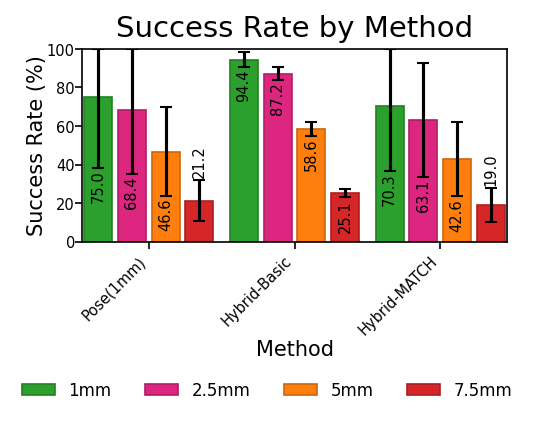

In [164]:
# ============================================================
# BLOCK 7: SUCCESS RATE BY METHOD (NOISE LEVELS AS BARS)
# ============================================================
# Import the new function
from analysis_utils import plot_rate_figure_by_method, NOISE_LEVEL_COLORS

fig, ax = plot_rate_figure_by_method(
    data=noise_data,
    method_names=list(METHOD_TAGS.keys()),
    level_labels=list(NOISE_LEVELS.keys()),
    level_col="noise_level",
    metric="success",
    title="Success Rate by Method",
    x_label="Method",
    y_label="Success Rate (%)",
    y_lim=SUCCESS_Y_LIM,
    y_ticks=SUCCESS_Y_TICKS,
    error_type=ERROR_TYPE,
    level_colors=NOISE_LEVEL_COLORS,
    filter_top_n=TOP_N_POLICIES,
    best_checkpoints=best_checkpoints_by_method,
)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

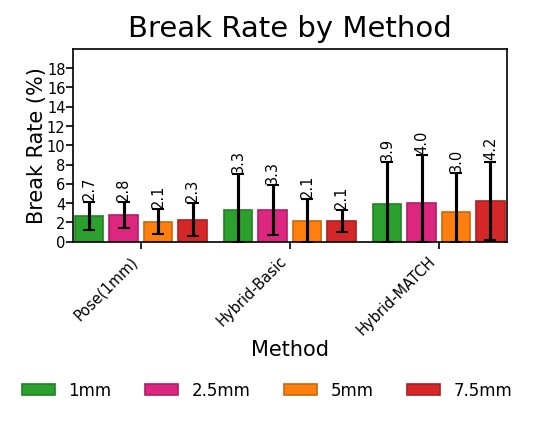

In [165]:
# ============================================================
# BLOCK 8: BREAK RATE BY METHOD (NOISE LEVELS AS BARS)
# ============================================================

fig, ax = plot_rate_figure_by_method(
    data=noise_data,
    method_names=list(METHOD_TAGS.keys()),
    level_labels=list(NOISE_LEVELS.keys()),
    level_col="noise_level",
    metric="breaks",
    title="Break Rate by Method",
    x_label="Method",
    y_label="Break Rate (%)",
    y_lim=BREAK_Y_LIM,
    y_ticks=BREAK_Y_TICKS,
    error_type=ERROR_TYPE,
    level_colors=NOISE_LEVEL_COLORS,
    filter_top_n=TOP_N_POLICIES,
    best_checkpoints=best_checkpoints_by_method,
)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [166]:
# ============================================================
# BLOCK 9: PRECISION / RECALL / F2 — FORCE CONTROL IN CONTACT
# ============================================================
importlib.reload(analysis_utils)
from analysis_utils import (
    download_eval_performance_data,
    CONTACT_COUNT_METRICS,
    compute_precision_recall_f2,
    compute_confusion_percentages,
)

# Filter to hybrid methods only (skip Pose — no force control switching)
HYBRID_METHODS = {k: v for k, v in METHOD_TAGS.items() if "pose" not in k.lower()}

# Download contact metrics for hybrid methods
contact_data = {}
for method_name, method_tag in HYBRID_METHODS.items():
    print(f"Downloading contact metrics for {method_name}...")
    contact_data[method_name] = download_eval_performance_data(
        api=api,
        method_tag=method_tag,
        best_checkpoints=best_checkpoints_by_method[method_name],
        extra_contact_metrics=CONTACT_COUNT_METRICS,
    )

# Compute and display P/R/F2 + confusion percentages for each axis grouping
for group_name, axes in [("XY", ["x", "y"]), ("Z", ["z"]), ("Full (XYZ)", ["x", "y", "z"])]:
    print("=" * 105)
    print(f"FORCE CONTROL P / R / F2 + CONFUSION %% — {group_name}")
    print("=" * 105)
    print(f"{'Method':<20} {'Precision':>14} {'Recall':>14} {'F2':>14} {'TP%':>14} {'FP%':>14} {'FN%':>14} {'TN%':>14}")
    print("-" * 105)
    for method_name in HYBRID_METHODS:
        df = contact_data[method_name]
        stats = compute_precision_recall_f2(df, axes=axes)
        conf = compute_confusion_percentages(df, axes=axes)
        p, r, f2 = stats["precision"], stats["recall"], stats["f2"]
        tp, fp, fn, tn = conf["TP"], conf["FP"], conf["FN"], conf["TN"]
        print(
            f"{method_name:<20} "
            f"{p['mean']:.3f} +/- {p['ci']:.3f}  "
            f"{r['mean']:.3f} +/- {r['ci']:.3f}  "
            f"{f2['mean']:.3f} +/- {f2['ci']:.3f}  "
            f"{tp['mean']:.1f} +/- {tp['ci']:.1f}  "
            f"{fp['mean']:.1f} +/- {fp['ci']:.1f}  "
            f"{fn['mean']:.1f} +/- {fn['ci']:.1f}  "
            f"{tn['mean']:.1f} +/- {tn['ci']:.1f}"
        )
    print()

FORCE CONTROL P / R / F2 + CONFUSION %% — XY
Method                    Precision         Recall             F2            TP%            FP%            FN%            TN%
---------------------------------------------------------------------------------------------------------
Hybrid-Basic         0.258 +/- 0.093  0.099 +/- 0.091  0.110 +/- 0.094  0.2 +/- 0.3  0.5 +/- 0.4  1.4 +/- 0.3  97.9 +/- 1.0
Hybrid-MATCH         0.149 +/- 0.034  0.040 +/- 0.018  0.046 +/- 0.019  0.1 +/- 0.0  0.3 +/- 0.1  1.7 +/- 1.0  97.9 +/- 1.1

FORCE CONTROL P / R / F2 + CONFUSION %% — Z
Method                    Precision         Recall             F2            TP%            FP%            FN%            TN%
---------------------------------------------------------------------------------------------------------
Hybrid-Basic         0.334 +/- 0.222  0.186 +/- 0.124  0.204 +/- 0.136  1.7 +/- 1.0  3.2 +/- 1.3  8.2 +/- 2.4  86.9 +/- 2.9
Hybrid-MATCH         0.116 +/- 0.070  0.103 +/- 0.121  0.101 +/- 0.107  0.